<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Classifying Grab's Customer Feedback into Ride Hailing and Delivery

> Authors: Irfan Muzafar, Ng Wei, Lim Zheng Gang
---
**Problem Statement:**  
How can we distinguish between customer feedback related to Grab's ride-hailing and delivery fast and accurately? 

**Target Audience:**
Grab Product Team

**Summary:**
- Product Manager is overwhelmed by vast user reviews; struggles to classify reviews between delivery and ride hailing.   
- Develop a NLP model to differentiate ride-hailing comments from delivery on Grab's Google Play Store.
- Training data: Uber and Uber Eats subreddit.
- Other data sources: App store reviews from Grab and Grab Driver applications as well as those from competitors:  
  - foodpanda  
  - Deliveroo  
  - Gojek  

There are a total of three notebooks for this project:  
 1. `01_Data_Collection.ipynb`   
 2. `02_Data_Cleaning_EDA.ipynb`   
 3. `03_Modelling_Evaluation_Conclusion.ipynb`   

---
**This Notebook**
- Clean and process the data we obtain in notebook 1 for modelling in notebook 3.
- Perform Exploratory Data Analysis (EDA) on app store data (Grab's and competitors)
- Perform n-gram analysis on subreddit comments scraped.

#### 1. Import Libraries and read CSV

In [14]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [2]:
data_uber = pd.read_csv("../datasets/reddit_uber_data_final.csv")
data_ubereats = pd.read_csv("../datasets/reddit_ubereats_data_final.csv")
data_grab = pd.read_csv("../datasets/grab_data_playstore.csv")
data_grab_driver = pd.read_csv("../datasets/grab_driver_data_playstore.csv")
data_fp = pd.read_csv("../datasets/fp_data_playstore.csv")
data_fp_driver = pd.read_csv("../datasets/fp_driver_data_playstore.csv")
data_droo = pd.read_csv("../datasets/droo_data_playstore.csv")
data_droo_driver = pd.read_csv("../datasets/droo_driver_data_playstore.csv")
data_gojek = pd.read_csv("../datasets/gojek_data_playstore.csv")
data_gojek_driver = pd.read_csv("../datasets/gojek_driver_data_playstore.csv")

#### 2. Data_Cleaning

In this section, we clean up data from our previous scraping efforts from the previous notebook titled `01_Data_Collection.ipynb` 

#####  2.1. Cleaning up NULL data and duplicated comments

We view the null data in subreddit dataframe and determine the course of action for them. We dropped all of our null values as they do not take up a substantial amount and null content does not benefit the analysis. 

In [3]:
print(data_uber[data_uber["body"].isnull()].head(5))
print(data_uber.isnull().sum())

     submission/comment id submission or comment body  up_votes
1                  1550eoq            submission  NaN     10172
1948               169vcan            submission  NaN      3989
2303               1bi5xwn            submission  NaN      3905
2789               157tw4c            submission  NaN      3721
3767               15hdt84            submission  NaN      3401
submission/comment id     0
submission or comment     0
body                     28
up_votes                  0
dtype: int64


In [4]:
print(data_ubereats[data_ubereats["body"].isnull()].head(5))
print(data_ubereats.isnull().sum())

     submission/comment id submission or comment body  up_votes
491                15iflwc            submission  NaN     18290
976                146387y            submission  NaN     16956
1465               14z1xsw            submission  NaN     16395
1947               14e7v2b            submission  NaN     13171
2657               15qdt7u            submission  NaN     10735
submission/comment id     0
submission or comment     0
body                     51
up_votes                  0
dtype: int64


We see that null values of the reddit data is due to empty submission body. We will proceed to drop these rows. 

In [5]:
uber_text = data_uber["body"].dropna()
ubereats_text = data_ubereats["body"].dropna()

We view the duplicated data in subreddit dataframe and determine the course of action for them.

In [6]:
duplicated_uber = data_uber[data_uber.duplicated(subset='body', keep=False)]['body'].value_counts()

print("Duplicated Uber:")
print(duplicated_uber)

Duplicated Uber:
body
[deleted]                                                                                                                                                                                                                                                                                                                                                                   530
[removed]                                                                                                                                                                                                                                                                                                                                                                    96
Lol                                                                                                                                                                                                                                               

In [7]:
duplicated_ubereats = data_ubereats[data_ubereats.duplicated(subset='body', keep=False)]['body'].value_counts()

print("Duplicated Ubereats:")
print(duplicated_ubereats)

Duplicated Ubereats:
body
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1516
Please Verify Your Email to Make Posts on r/UberEATS. To verify your email address, please do the following: Go to www.reddit.com/verify Enter your Reddit password. Enter your email address. Click send verification email. Open the email from Reddit. Click the verification link. **If you have any issues or question about verifying your email, please contact Reddit admins at r/help**\n\n*I am a 

We see that there is less than 1.6k lines of duplicated body for both dataframes. Most of which are unhelpful comments such as "deleted","removed" etc. We will proceed to drop these to prevent them from influcencing our analysis. 

In [8]:
uber_text = uber_text.drop_duplicates()
ubereats_text = ubereats_text.drop_duplicates() 

For the app store data, we will be dropping all null rows and duplicated rows regardless because:

- We aim to perform sentiment analysis on them. Therefore, null comments will not matter.
- They will not be included in the modeling process.


In [9]:
fp_text = data_fp["content"].dropna()
fp_driver_text = data_fp_driver["content"].dropna()
droo_text = data_droo["content"].dropna()
droo_driver_text = data_droo_driver["content"].dropna()
gojek_text = data_gojek["content"].dropna()
gojek_driver_text = data_gojek_driver["content"].dropna()
grab_text = data_grab["content"].dropna()
grab_driver_text = data_grab_driver["content"].dropna()

In [10]:
fp_text = fp_text.drop_duplicates() 
fp_driver_text = fp_driver_text.drop_duplicates() 
droo_text = droo_text.drop_duplicates() 
droo_driver_text = droo_driver_text.drop_duplicates() 
gojek_text = gojek_text.drop_duplicates() 
gojek_driver_text = gojek_driver_text.drop_duplicates() 
grab_text = grab_text.drop_duplicates() 
grab_driver_text = grab_driver_text.drop_duplicates() 

##### 2.2. Preparing file for modelling in notebook 3

Lemmatize words and create final dataframe for analysis. 

Define function to lemmatize sentences and define a function (get_wordnet_pos) so that we can try to identify the correct POS for lemmatize function using pos_tag. 

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
def lemmatize_sentence(sentence):
    words = word_tokenize(sentence)
    list_lemmatized_words = [(lemmatizer.lemmatize(word, get_wordnet_pos(word))).lower() for word in words]
    return ' '.join(list_lemmatized_words)

Lemmatize our uber and ubereats data

In [15]:
lemmatizer = WordNetLemmatizer()
lemmatize_uber_text = [lemmatize_sentence(sentence) for sentence in uber_text]
lemmatize_ubereats_text = [lemmatize_sentence(sentence) for sentence in ubereats_text]

In [16]:
lemmatize_uber_df = pd.DataFrame(lemmatize_uber_text)
output_path = '../datasets/lemma_list_uber_data.csv'
lemmatize_uber_df.to_csv(output_path, index=False)

In [17]:
lemmatize_ubereats_df = pd.DataFrame(lemmatize_ubereats_text)
output_path = '../datasets/lemma_list_ubereats_data.csv'
lemmatize_ubereats_df.to_csv(output_path, index=False)

Create cleaned_data for model training in notebook 3

In [18]:
df_uber = pd.DataFrame()
df_ubereats = pd.DataFrame()
df_uber["body"]=lemmatize_uber_text
df_uber["ubereats"]=0
df_ubereats["body"]=lemmatize_ubereats_text
df_ubereats["ubereats"]=1
df = pd.concat([df_uber, df_ubereats], ignore_index=True)

Save data for notebook 3 processing

In [19]:
output_path = '../datasets/cleaned_data.csv'
df.to_csv(output_path, index=False)

#### 3. Exploratory Data Analysis (App Store Data)

##### Instantiate model for Sentiment Analysis and sentiment analysis for that each app.  

The approach involves performing sentiment analysis on individual reviews gathered from the app store. Negative reviews are assigned negative values with corresponding magnitudes in the "score" column, and vice versa. The aggregate sentiment score is determined as the mean of the "score" column.

In [20]:
sent = pipeline('sentiment-analysis')

fp_text["score"] = fp_text.map(lambda x: (sent(str(x)))[0]["score"] if (sent(str(x)))[0]["label"] == "POSITIVE" else (sent(str(x)))[0]["score"]*(-1))
fp_driver_text["score"] = fp_driver_text.map(lambda x: (sent(str(x)))[0]["score"] if (sent(str(x)))[0]["label"] == "POSITIVE" else (sent(str(x)))[0]["score"]*(-1))
grab_text["score"] = grab_text.map(lambda x: (sent(str(x)))[0]["score"] if (sent(str(x)))[0]["label"] == "POSITIVE" else (sent(str(x)))[0]["score"]*(-1))
grab_driver_text["score"] = grab_driver_text.map(lambda x: (sent(str(x)))[0]["score"] if (sent(str(x)))[0]["label"] == "POSITIVE" else (sent(str(x)))[0]["score"]*(-1))
droo_text["score"] = droo_text.map(lambda x: (sent(str(x)))[0]["score"] if (sent(str(x)))[0]["label"] == "POSITIVE" else (sent(str(x)))[0]["score"]*(-1))
droo_driver_text["score"] = droo_driver_text.map(lambda x: (sent(str(x)))[0]["score"] if (sent(str(x)))[0]["label"] == "POSITIVE" else (sent(str(x)))[0]["score"]*(-1))
gojek_text["score"] = gojek_text.map(lambda x: (sent(str(x)))[0]["score"] if (sent(str(x)))[0]["label"] == "POSITIVE" else (sent(str(x)))[0]["score"]*(-1))
gojek_driver_text["score"] = gojek_driver_text.map(lambda x: (sent(str(x)))[0]["score"] if (sent(str(x)))[0]["label"] == "POSITIVE" else (sent(str(x)))[0]["score"]*(-1))

fp_text_mean = fp_text["score"].mean()
fp_driver_text_mean = fp_driver_text["score"].mean()
grab_text_mean = grab_text["score"].mean()
grab_driver_text_mean = grab_driver_text["score"].mean()
droo_text_mean = droo_text["score"].mean()
droo_driver_text_mean = droo_driver_text["score"].mean()
gojek_text_mean = gojek_text["score"].mean()
gojek_driver_text_mean = gojek_driver_text["score"].mean()

print(f"foodpanda:{fp_text_mean}")
print(f"foodpanda_driver:{fp_driver_text_mean}")
print(f"droo:{droo_text_mean}")
print(f"droo_driver:{droo_driver_text_mean}")
print(f"grab:{grab_text_mean}")
print(f"grab_driver:{grab_driver_text_mean}")
print(f"gojek:{gojek_text_mean}")
print(f"gojek_driver:{gojek_driver_text_mean}")

#average run time 4 minute

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.



foodpanda:-0.34163299702309274
foodpanda_driver:-0.4420857322020609
droo:-0.1640005520622146
droo_driver:-0.018319693895486686
grab:0.07599458652873371
grab_driver:-0.27384760226422583
gojek:-0.5454433667381533
gojek_driver:-0.7033153919073252


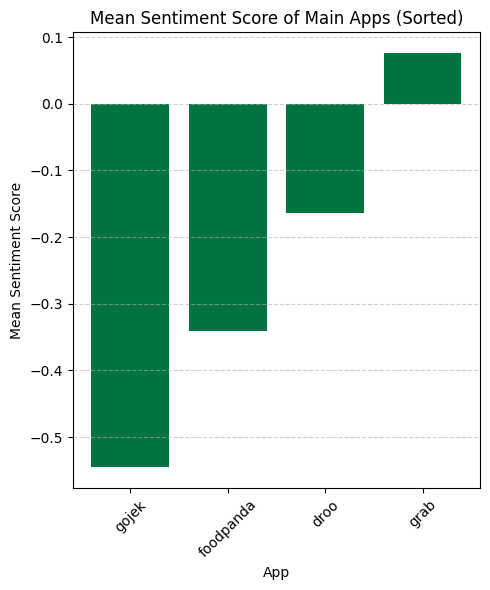

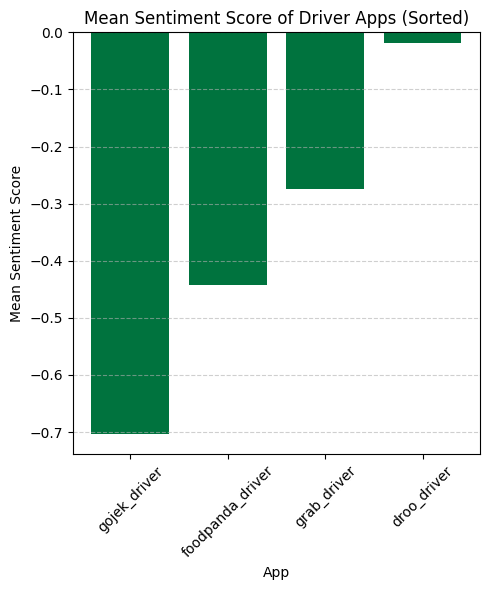

In [21]:
# plot mean sentiment scores
mean_scores_main_app = {
    'foodpanda': fp_text_mean,
    'droo': droo_text_mean,
    'grab': grab_text_mean,
    'gojek': gojek_text_mean
}

mean_scores_driver_app = {
    'foodpanda_driver': fp_driver_text_mean,
    'droo_driver': droo_driver_text_mean,
    'grab_driver': grab_driver_text_mean,
    'gojek_driver': gojek_driver_text_mean
}

grab_green = "#00B14F"
grab_light_green = "#E0FFED"
grab_dark_green = "#00733E"

sorted_scores_main_app = dict(sorted(mean_scores_main_app.items(), key=lambda item: item[1]))
sorted_scores_driver_app = dict(sorted(mean_scores_driver_app.items(), key=lambda item: item[1]))


plt.figure(figsize=(5, 6))
plt.bar(sorted_scores_main_app.keys(), sorted_scores_main_app.values(), color=grab_dark_green)
plt.title('Mean Sentiment Score of Main Apps (Sorted)')
plt.ylabel('Mean Sentiment Score')
plt.xlabel('App')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis = "y", linestyle = "--", alpha = 0.6)
plt.show()

plt.figure(figsize=(5, 6))
plt.bar(sorted_scores_driver_app.keys(), sorted_scores_driver_app.values(), color=grab_dark_green)
plt.title('Mean Sentiment Score of Driver Apps (Sorted)')
plt.ylabel('Mean Sentiment Score')
plt.xlabel('App')
plt.xticks(rotation=45)
plt.grid(axis = "y", linestyle = "--", alpha = 0.6)
plt.tight_layout()
plt.show()

In comparing Grab and Grab Driver with other platforms, Grab exhibits a sentiment score of approximately 0.07, suggesting a slightly positive sentiment but nearing neutrality. Conversely, Grab Driver shows a sentiment score of approximately -0.28, indicating a more negative sentiment. When compared to other platforms like foodpanda and droo, Grab's sentiment leans towards the positive side but remains relatively neutral. This comparison underscores the nuanced perceptions users have towards different aspects of the ride-hailing and food delivery services, highlighting potential areas for improvement within the Grab ecosystem.

#### 4. Exploratory Data Analysis (SubReddit Data)

##### 4.1. Creation of new stop words list

In [22]:
# read csv to avoid running lemmatization which takes a very long time
lemmatize_uber_df = pd.read_csv('../datasets/lemma_list_uber_data.csv')
lemmatize_ubereats_df = pd.read_csv('../datasets/lemma_list_ubereats_data.csv')

In [23]:
# only take the first column of each df
lemmatize_uber_text = lemmatize_uber_df['0']
lemmatize_ubereats_text = lemmatize_ubereats_df['0']

Perform preliminary 1-n-gram analysis for both data

['10' '100' '15' '20' '30' '50' 'accept' 'account' 'actually' 'address'
 'ago' 'alcohol' 'app' 'area' 'ask' 'away' 'bad' 'bag' 'base' 'best' 'big'
 'bro' 'business' 'ca' 'cancel' 'car' 'care' 'case' 'cause' 'change'
 'charge' 'come' 'comment' 'company' 'complain' 'cost' 'crazy' 'customer'
 'damn' 'day' 'definitely' 'deliver' 'delivery' 'didn' 'different' 'doesn'
 'dog' 'dollar' 'don' 'door' 'doordash' 'drink' 'drive' 'driver' 'drop'
 'dude' 'easy' 'eat' 'eats' 'employee' 'end' 'exactly' 'expect' 'extra'
 'fact' 'fee' 'feel' 'food' 'free' 'fuck' 'gas' 'gate' 'gon' 'good'
 'great' 'guess' 'guy' 'hand' 'happen' 'hard' 'hate' 'help' 'high' 'home'
 'hope' 'hour' 'house' 'http' 'instead' 'isn' 'issue' 'job' 'just' 'kind'
 'kitchen' 'know' 'law' 'leave' 'left' 'let' 'life' 'like' 'line'
 'literally' 'little' 'live' 'll' 'lmao' 'lol' 'long' 'look' 'lot' 'love'
 'low' 'make' 'man' 'maybe' 'mean' 'message' 'mile' 'minute' 'money' 'na'
 'need' 'new' 'nice' 'night' 'number' 'offer' 'oh' 'old' 'op'

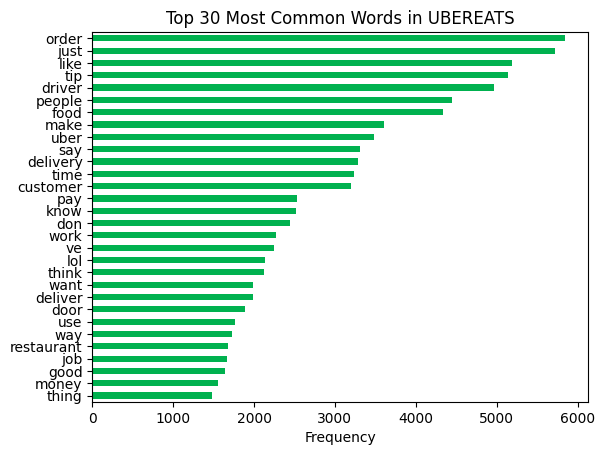

In [24]:
#define plot colours

grab_green = "#00B14F"
grab_light_green = "#E0FFED"
grab_dark_green = "#00733E"

cvec_ubereats = CountVectorizer(stop_words = "english", max_features = 200)
cvec_ubereats.fit(lemmatize_ubereats_text)
lemmatize_ubereats_text_transformed = cvec_ubereats.transform(lemmatize_ubereats_text)

ubereats_text_df = pd.DataFrame(lemmatize_ubereats_text_transformed.todense(), 
                          columns=cvec_ubereats.get_feature_names_out())
ubereats_text_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = grab_green)
plt.title('Top 30 Most Common Words in UBEREATS')
plt.xlabel('Frequency')
print(cvec_ubereats.get_feature_names_out())

['10' '100' '15' '20' '30' '50' 'absolutely' 'accept' 'account' 'actually'
 'add' 'agree' 'airport' 'allow' 'app' 'area' 'ask' 'away' 'bad' 'big'
 'business' 'ca' 'cancel' 'cancellation' 'car' 'care' 'case' 'cash'
 'cause' 'change' 'charge' 'check' 'come' 'comment' 'company' 'complain'
 'cost' 'customer' 'day' 'deal' 'definitely' 'delivery' 'didn' 'different'
 'doesn' 'dog' 'don' 'door' 'drive' 'driver' 'drop' 'dude' 'end' 'expect'
 'experience' 'extra' 'fact' 'far' 'fare' 'fee' 'feel' 'food' 'friend'
 'fuck' 'gas' 'good' 'guy' 'happen' 'hard' 'help' 'high' 'home' 'hour'
 'house' 'instead' 'insurance' 'isn' 'issue' 'job' 'just' 'kid' 'kind'
 'know' 'law' 'leave' 'left' 'let' 'life' 'like' 'likely' 'literally'
 'little' 'live' 'll' 'location' 'lol' 'long' 'look' 'lose' 'lot' 'low'
 'lyft' 'make' 'man' 'maybe' 'mean' 'message' 'mile' 'minute' 'money' 'na'
 'need' 'new' 'night' 'offer' 'oh' 'op' 'option' 'order' 'paid'
 'passenger' 'pax' 'pay' 'people' 'person' 'pet' 'phone' 'pick' 'place

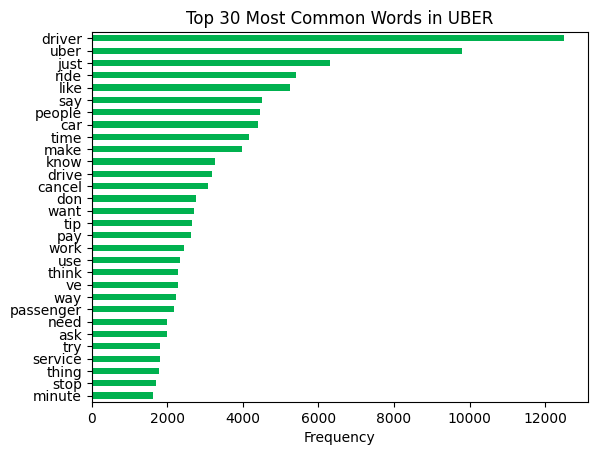

In [25]:
cvec_uber = CountVectorizer(stop_words = "english", max_features = 200)
cvec_uber.fit(lemmatize_uber_text)
lemmatize_uber_text_transformed = cvec_uber.transform(lemmatize_uber_text)

uber_text_df = pd.DataFrame(lemmatize_uber_text_transformed.todense(), 
                          columns=cvec_uber.get_feature_names_out())
uber_text_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = grab_green)
plt.title('Top 30 Most Common Words in UBER')
plt.xlabel('Frequency')
print(cvec_uber.get_feature_names_out())

There are many stopwords that are not included in the default stopwords. As such, we append the additional words to the original list so as not to cloud our analysis. We select the additional words from the bar charts above, words which do not help us with our classifier. For example, "like", "just" and "say".

Define our new list of stop_words below for future analysis. The stop words are defined based on the 1-n gram above.

In [26]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

additional_stop_words = ["just","like","say","people","make","time","don","want","it", "know", "uber"]

stop_words_new = list(ENGLISH_STOP_WORDS)
for word in additional_stop_words:
    stop_words_new.append(word)

##### 4.2. Perform 1 n-gram analysis

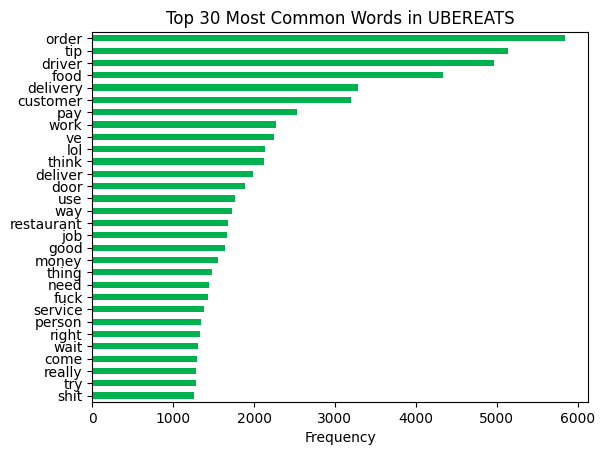

In [27]:
cvec_ubereats = CountVectorizer(stop_words = stop_words_new, max_features = 100)
cvec_ubereats.fit(lemmatize_ubereats_text)
lemmatize_ubereats_text_transformed = cvec_ubereats.transform(lemmatize_ubereats_text)

ubereats_text_df = pd.DataFrame(lemmatize_ubereats_text_transformed.todense(),
                          columns=cvec_ubereats.get_feature_names_out())
ubereats_text_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = grab_green)
plt.title('Top 30 Most Common Words in UBEREATS')
plt.xlabel('Frequency');

As expected, we see service type specific words rank high in our frequency analysis for uberEATS:

"Order" in first place, "Food" in fourth place", and "Delivery" in fifth place. These "strong" words, which will most likely be in ubearEATS instead of uber, will help with our classifier.

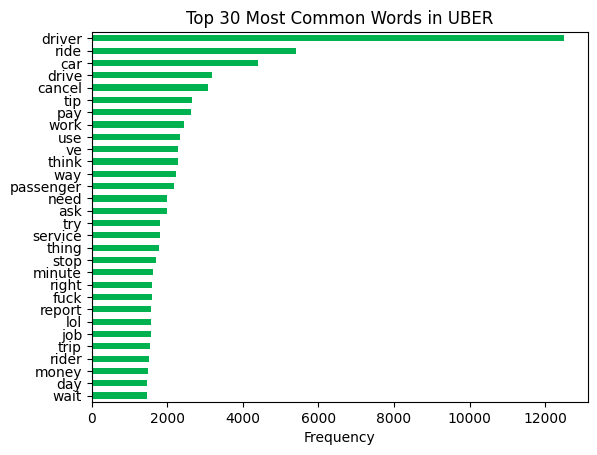

In [28]:
cvec_uber = CountVectorizer(stop_words = stop_words_new, max_features = 100)
cvec_uber.fit(lemmatize_uber_text)
lemmatize_uber_text_transformed = cvec_uber.transform(lemmatize_uber_text)

uber_text_df = pd.DataFrame(lemmatize_uber_text_transformed.todense(), 
                          columns=cvec_uber.get_feature_names_out())
uber_text_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = grab_green)
plt.title('Top 30 Most Common Words in UBER')
plt.xlabel('Frequency');

As expected, we see service type specific words rank high in our frequency analysis for uber:

"Ride" in second place, "Car" in third place", and "Drive" in fourth place. These "strong" words, which will most likely be in uber instead of uberEATS, will help with our classifier.

There are also words that appear in both top 30 words. For example, "driver" and "money". These words are considered ambiguous as we can predict them to be in either uber or uberEATS subreddit.

##### 4.3. Perform 2 n-gram analysis

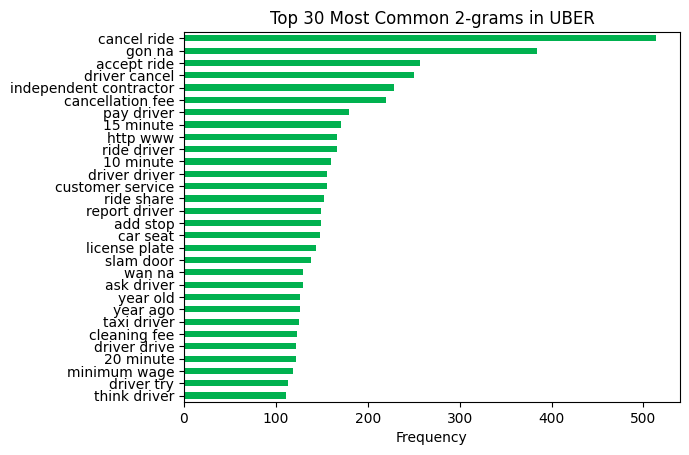

In [29]:
cvec_uber = CountVectorizer(stop_words = stop_words_new, max_features = 100, ngram_range=(2,2))
cvec_uber.fit(lemmatize_uber_text)
lemmatize_uber_text_transformed = cvec_uber.transform(lemmatize_uber_text)

uber_text_df = pd.DataFrame(lemmatize_uber_text_transformed.todense(), 
                          columns=cvec_uber.get_feature_names_out())
uber_text_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = grab_green)
plt.title('Top 30 Most Common 2-grams in UBER')
plt.xlabel('Frequency');

We can see some common phrases that are distinct to uber only:

"cancel ride" in first place, "accept ride" in third place", and "ride share" in fourteenth place. These "strong" phrases, which will most likely be in uber instead of uber, will help with our classifier.

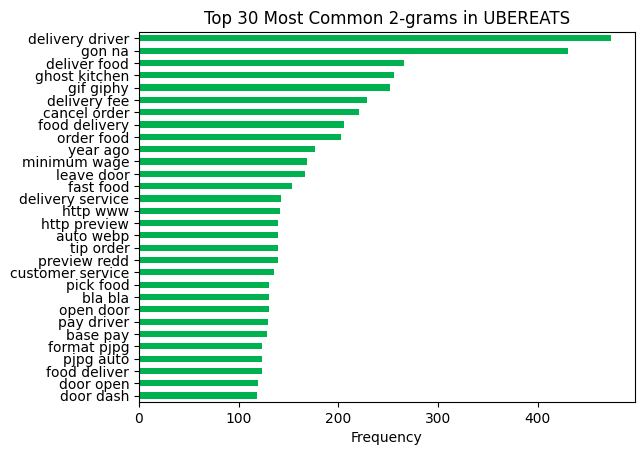

In [30]:
cvec_ubereats = CountVectorizer(stop_words = stop_words_new, max_features = 100, ngram_range=(2,2))
cvec_ubereats.fit(lemmatize_ubereats_text)
lemmatize_ubereats_text_transformed = cvec_ubereats.transform(lemmatize_ubereats_text)
ubereats_text_df = pd.DataFrame(lemmatize_ubereats_text_transformed.todense(), 
                          columns=cvec_ubereats.get_feature_names_out())
ubereats_text_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = grab_green)
plt.title('Top 30 Most Common 2-grams in UBEREATS')
plt.xlabel('Frequency');

We can see some common phrases that are distinct to uberEATS only:

"delivery driver" in first place, "deliver food" in third place", and "cancel order" in seventh place. These "strong" phrases, which will most likely be in uber instead of uberEATS, will help with our classifier.

##### 4.4. Perform 3 n-gram analysis

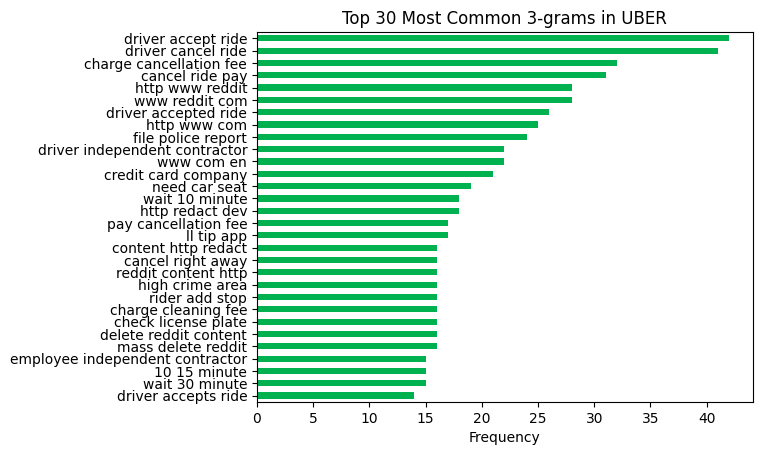

In [31]:
cvec_uber = CountVectorizer(stop_words = stop_words_new, max_features = 100, ngram_range=(3,3))
cvec_uber.fit(lemmatize_uber_text)
lemmatize_uber_text_transformed = cvec_uber.transform(lemmatize_uber_text)

uber_text_df = pd.DataFrame(lemmatize_uber_text_transformed.todense(), 
                          columns=cvec_uber.get_feature_names_out())
uber_text_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = grab_green)
plt.title('Top 30 Most Common 3-grams in UBER')
plt.xlabel('Frequency');

"driver accept ride" is the most common 3-gram in uber. This phrase is very unlikely to appear in uberEATS.

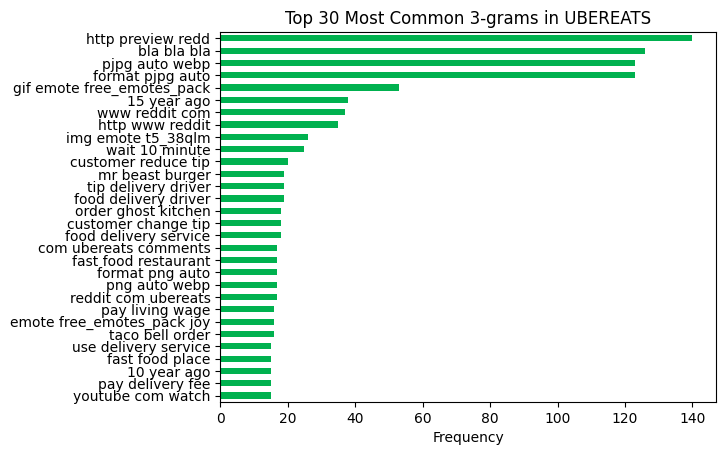

In [32]:
cvec_ubereats = CountVectorizer(stop_words = stop_words_new, max_features = 100, ngram_range=(3,3))
cvec_ubereats.fit(lemmatize_ubereats_text)
lemmatize_ubereats_text_transformed = cvec_ubereats.transform(lemmatize_ubereats_text)

ubereats_text_df = pd.DataFrame(lemmatize_ubereats_text_transformed.todense(), 
                          columns=cvec_ubereats.get_feature_names_out())
ubereats_text_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = grab_green)
plt.title('Top 30 Most Common 3-grams in UBEREATS')
plt.xlabel('Frequency');

"mr beast burger" is the most common 3-gram, that is meaningful, in uberEATS. This phrase is very unlikely to appear in uberEATS.

##### 4.5. Perform 1 to 3 n-gram analysis

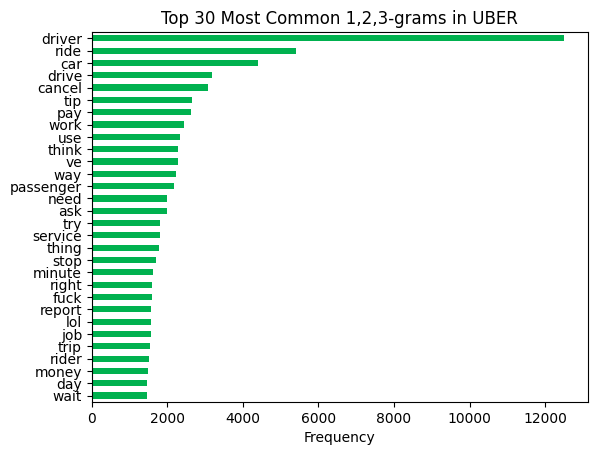

In [33]:
cvec_uber = CountVectorizer(stop_words = stop_words_new, max_features = 1000, ngram_range=(1,3))
cvec_uber.fit(lemmatize_uber_text)
lemmatize_uber_text_transformed = cvec_uber.transform(lemmatize_uber_text)

uber_text_df = pd.DataFrame(lemmatize_uber_text_transformed.todense(), 
                          columns=cvec_uber.get_feature_names_out())
uber_text_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = grab_green)
plt.title('Top 30 Most Common 1,2,3-grams in UBER')
plt.xlabel('Frequency');

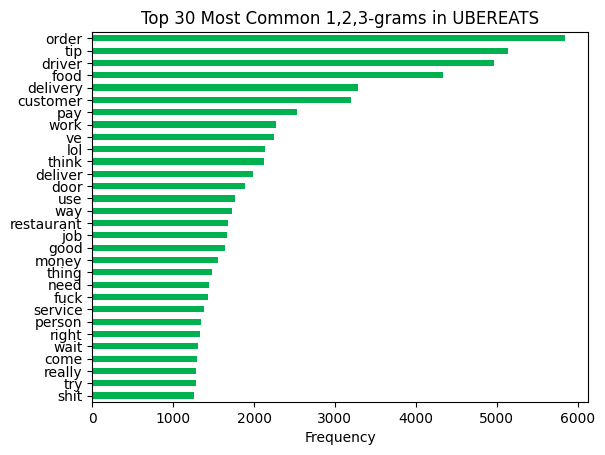

In [34]:
cvec_ubereats = CountVectorizer(stop_words = stop_words_new, max_features = 1000, ngram_range=(1,3))
cvec_ubereats.fit(lemmatize_ubereats_text)
lemmatize_ubereats_text_transformed = cvec_ubereats.transform(lemmatize_ubereats_text)

ubereats_text_df = pd.DataFrame(lemmatize_ubereats_text_transformed.todense(), 
                          columns=cvec_ubereats.get_feature_names_out())
ubereats_text_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = grab_green)
plt.title('Top 30 Most Common 1,2,3-grams in UBEREATS')
plt.xlabel('Frequency');

We see that high frequency of words like ride, car, drive, passenger exclusively in Uber subreddit. And high frequency of order, delivery, and restaurant exclusively in Ubereats subreddit.

In addition, we also noticed that the presence of common words between both service types like driver, and time. We also identifed that it goes against our belief that delivery uses the term "rider" more than "driver". In the Singapore context, we think that we use "riders" instead of "drivers" when we talk about the people who deliver items/food.

##### 4.6. More EDA (Histogram and Boxplot)

We will explore some general distributions for number of times words appear in each subreddit.

In [35]:
grab_green = "#00B14F"
grab_light_green = "#E0FFED"
grab_dark_green = "#00733E"

cvec_ubereats = CountVectorizer(stop_words = stop_words_new, max_features = 200)
cvec_ubereats.fit(lemmatize_ubereats_text)
lemmatize_ubereats_text_transformed = cvec_ubereats.transform(lemmatize_ubereats_text)

ubereats_text_df = pd.DataFrame(lemmatize_ubereats_text_transformed.todense(), 
                          columns=cvec_ubereats.get_feature_names_out())
ubereats_text_df = ubereats_text_df.T
ubereats_row_sums = ubereats_text_df.sum(axis=1)
ubereats_row_sums

10        832
100       395
15        444
20        649
30        375
         ... 
wouldn    348
wrong     721
yeah      953
year      948
yes       543
Length: 200, dtype: int64

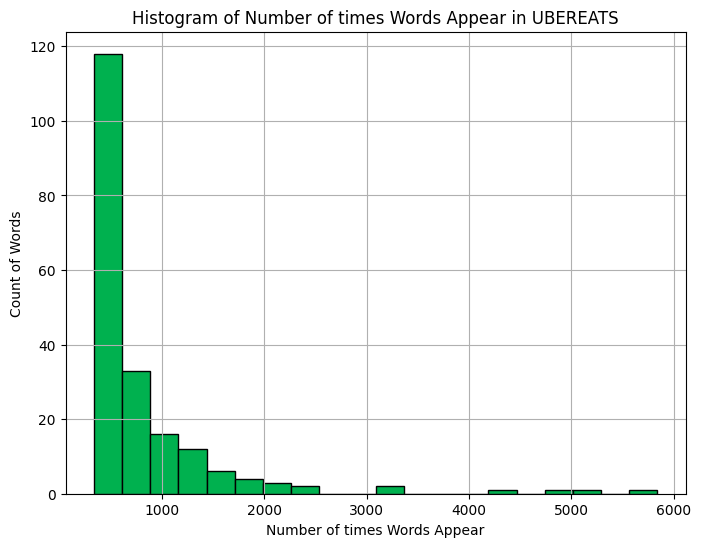

In [36]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(ubereats_row_sums, bins=20, color=grab_green, edgecolor='black')  # 10 bins for the histogram
plt.xlabel('Number of times Words Appear')
plt.ylabel('Count of Words')
plt.title('Histogram of Number of times Words Appear in UBEREATS')
plt.grid(True)
plt.show()

The plot above is a histogram for the number of times words appear in uberEATS. From the plot, majority of the words appear less than 1000 times. Now lets see the histogram for uber.

In [37]:
cvec_uber = CountVectorizer(stop_words = stop_words_new, max_features = 200)
cvec_uber.fit(lemmatize_uber_text)
lemmatize_uber_text_transformed = cvec_uber.transform(lemmatize_uber_text)

uber_text_df = pd.DataFrame(lemmatize_uber_text_transformed.todense(), 
                          columns=cvec_uber.get_feature_names_out())
uber_text_df = uber_text_df.T
uber_row_sums = uber_text_df.sum(axis=1)

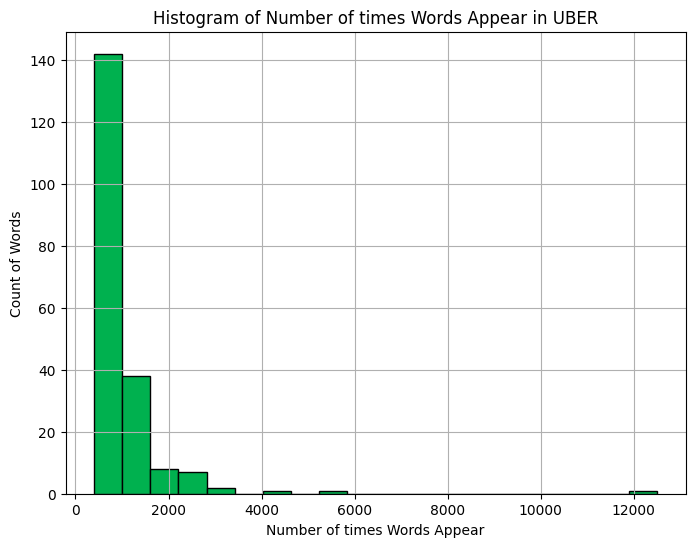

In [38]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(uber_row_sums, bins=20, color=grab_green, edgecolor='black')  # 10 bins for the histogram
plt.xlabel('Number of times Words Appear')
plt.ylabel('Count of Words')
plt.title('Histogram of Number of times Words Appear in UBER')
plt.grid(True)
plt.show()

The plot above is a histogram for the number of times words appear in uber. Similarly, majority of the words appear less than 1000 times. We do not observe much difference. Lets try plotting boxplots to see if we can get some insights.

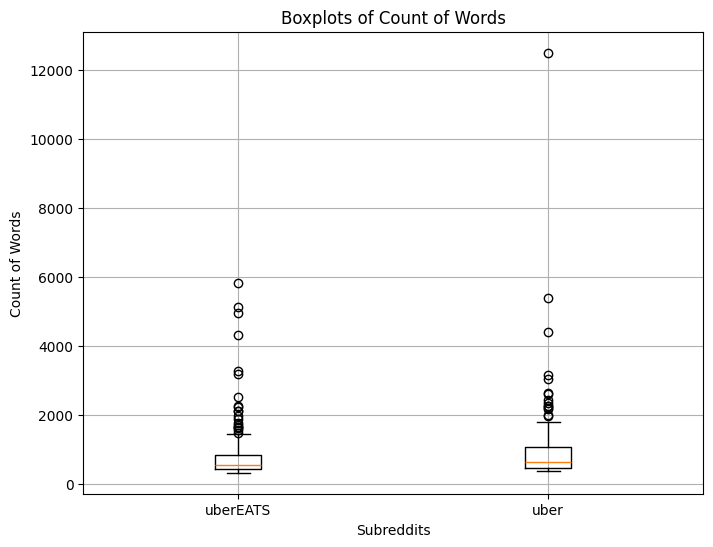

In [39]:
# Plot boxplot
plt.figure(figsize=(8, 6))
boxplot = plt.boxplot([ubereats_row_sums, uber_row_sums], labels=['uberEATS', 'uber'])
plt.xlabel('Subreddits')
plt.ylabel('Count of Words')
plt.title('Boxplots of Count of Words')
plt.grid(True)
plt.show()

In [40]:
# Get outliers
outliers = [item.get_ydata() for item in boxplot['fliers']]
print("Outliers:")
for i, outlier_data in enumerate(outliers):
    print(f"Data {i+1}: {outlier_data}")

Outliers:
Data 1: [3196 1981 3288 1894 4967 4335 1635 1669 2134 1560 5842 2532 1672 1481
 2120 5146 1764 2242 1732 2275]
Data 2: [ 1988  3065  4405  3178 12508  2002  2177  2623  5404  2273  2649  2343
  2273  2224  2430]


In [41]:
uber_row_sums = pd.DataFrame(uber_row_sums)
uber_row_sums.sort_values(by=0, ascending=False)

,0
driver,12508
ride,5404
car,4405
drive,3178
cancel,3065
...,...
ok,396
week,396
free,396
able,395


The plot above is a boxplot for the number of times words appear in uber and uberEATS. There are many outliers for count of words of more than 1000 for both subreddits. In uber, we also observe the furthest outlier, which is the value of 12508. That is the word "driver".

Next, we will try exploring boxplots for number of words in each comment, ie each row. We will have to tokenise each row and count the number of words in each row.

In [42]:
# count number of words on each row
# Tokenization function
def tokenize_df(text):
    return word_tokenize(text)

# Apply tokenization function to each row
lemmatize_ubereats_df['tokens'] = lemmatize_ubereats_df['0'].apply(tokenize_df)
lemmatize_uber_df['tokens'] = lemmatize_uber_df['0'].apply(tokenize_df)

# Find the number of words in each row
lemmatize_ubereats_df['num_words'] = lemmatize_ubereats_df['0'].apply(len)
lemmatize_uber_df['num_words'] = lemmatize_uber_df['0'].apply(len)

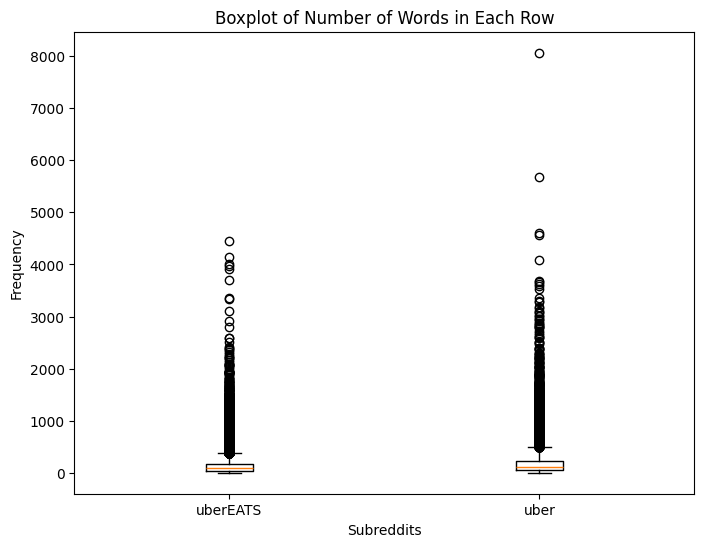

In [43]:
# Plot boxplot
plt.figure(figsize=(8, 6))
boxplot2 = plt.boxplot([lemmatize_ubereats_df['num_words'],lemmatize_uber_df['num_words']], labels=['uberEATS','uber'])
plt.xlabel('Subreddits')
plt.ylabel('Frequency')
plt.title('Boxplot of Number of Words in Each Row')
plt.show()

In [44]:
# Get outliers
outliers = [item.get_ydata() for item in boxplot2['fliers']]
print("Outliers:")
for i, outlier_data in enumerate(outliers):
    print(f"Data {i+1}: {outlier_data}")

Outliers:
Data 1: [ 860  761 1681 ...  400  434  717]
Data 2: [ 592  501 1047 ...  562  693 1240]


In [45]:
lemmatize_uber_df.sort_values(by='num_words', ascending=False)

,0,tokens,num_words
30122,2 : : : let 's look at this from another persp...,"[2, :, :, :, let, 's, look, at, this, from, an...",8064
23780,"if you want a more detailed , correct explanat...","[if, you, want, a, more, detailed, ,, correct,...",5684
12644,i be come home from the airport and i be creep...,"[i, be, come, home, from, the, airport, and, i...",4609
9226,ha😂😂 tell me you don ’ t drive without tell me...,"[ha😂😂, tell, me, you, don, ’, t, drive, withou...",4572
17554,disregard what any other person has commented ...,"[disregard, what, any, other, person, has, com...",4092
...,...,...,...
15189,.,[.],1
13215,🤔,[🤔],1
10667,💯,[💯],1
29695,🙄,[🙄],1


There are many outliers for number of words in each row above around 500, for both subreddits. In uber, we also observe the furthest outlier, which is the value of above 8000. This means that there is a comment on the uber subreddit which has a word count of 8064.

In [46]:
lemmatize_uber_df.iloc[30122][0]

C:\Users\user\AppData\Local\Temp\ipykernel_7284\2178133788.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lemmatize_uber_df.iloc[30122][0]


"2 : : : let 's look at this from another perspective . what if there be an independent coffee truck own by a single operator who serve coffee outside of the courthouse downtown during the week . let 's say he be first of all unable to set the rate he sell his coffee at , i stead his payment acceptance company , such a square , decides the price base on where he decides to set up his card . here each cup of hot coffee be $ 1 , and any flavor at it or what 50 cent . never mind you just like we have to pay for our own gas , he have to pay for his own supply . i wo n't be calculate that but just remember that and the process of think about how this work . so he sell his coffee 1 dollar here or 1.50 . but now it 's lunch time he have 10 people in line . the first pay 1 $ . the second find they 're pay 3 $ for a 1 dollar cup of coffee , the price change on the square control sign . now normal square take 6 cent from coffee and 3 cent from flavor . leaving 94 or 47 cent for coffee and flavor

##### 4.7. Sentiment Analysis on Subreddit comments

We do a sentiment analysis on subreddits comment for a comparison with the app store comments.

In [47]:
uber_text_sample = uber_text.sample(n=500, random_state=42) 
ubereats_text_sample = ubereats_text.sample(n=500, random_state=42)

uber_text_sample["score"] = uber_text_sample.map(lambda x: sent(str(x))[0]["score"] if sent(str(x))[0]["label"] == "POSITIVE" else -sent(str(x))[0]["score"])
ubereats_text_sample["score"] = ubereats_text_sample.map(lambda x: sent(str(x))[0]["score"] if sent(str(x))[0]["label"] == "POSITIVE" else -sent(str(x))[0]["score"])

# Calculating the mean sentiment score
uber_text_mean = uber_text_sample["score"].mean()
ubereats_text_mean = ubereats_text_sample["score"].mean()

print(f"Uber mean sentiment score: {uber_text_mean}")
print(f"UberEats mean sentiment score: {ubereats_text_mean}")

Uber mean sentiment score: -0.6043085616827011
UberEats mean sentiment score: -0.482267355799675


The sentiments are negative which is good since the app store reviews are also negative in generally, especially the driver application.  

#### 5. Expected Output file
At the end of this notebook, we expect to have the following files in our dataset folder, ready for analysis in notebook 3:

- `cleaned_data.csv`

#### 6. Presentation Materials

This section generates some of the charts that are not generated above for solely for presentation purposes.

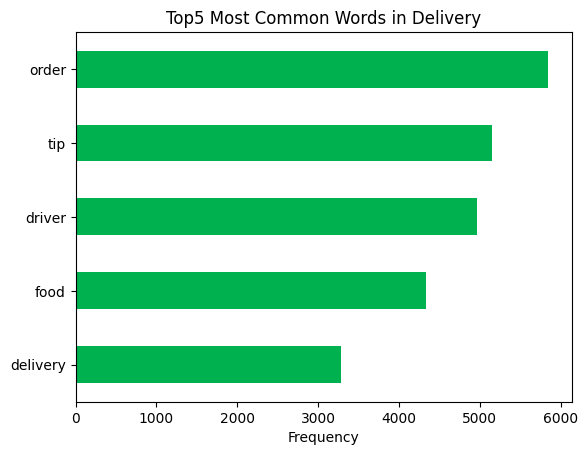

In [48]:
stop_words_new.append("uber")
cvec_ubereats = CountVectorizer(stop_words = stop_words_new, max_features = 50)
cvec_ubereats.fit(lemmatize_ubereats_text)
lemmatize_ubereats_text_transformed = cvec_ubereats.transform(lemmatize_ubereats_text)

ubereats_text_df = pd.DataFrame(lemmatize_ubereats_text_transformed.todense(),
                          columns=cvec_ubereats.get_feature_names_out())
ubereats_text_df.sum().sort_values(ascending=True).tail(5).plot(kind='barh', color = grab_green)

plt.title("Top5 Most Common Words in Delivery")
plt.xlabel('Frequency');

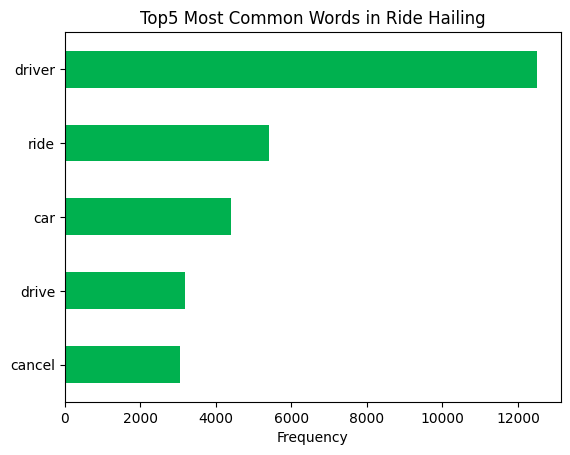

In [49]:
cvec_uber = CountVectorizer(stop_words = stop_words_new, max_features = 50)
cvec_uber.fit(lemmatize_uber_text)
lemmatize_uber_text_transformed = cvec_uber.transform(lemmatize_uber_text)

uber_text_df = pd.DataFrame(lemmatize_uber_text_transformed.todense(), 
                          columns=cvec_uber.get_feature_names_out())
uber_text_df.sum().sort_values(ascending=True).tail(5).plot(kind='barh', color = grab_green)

plt.title("Top5 Most Common Words in Ride Hailing")
plt.xlabel('Frequency');